## Stock Project: Initial LSTM Training
### Name: Aiden McLean, Lei Wang, Suraj
## Date: Nov 1, 2024

# Overview of Work Done
In this project, we are exploring different LSTM models for stock price prediction using the Tesla dataset. The work completed so far includes:
- Data preprocessing (handling missing values, normalization).
- Initial model training with multiple LSTM architectures (Single Layer, Stacked, and Bidirectional LSTMs).
- Preliminary evaluation and visualization of model performance through loss curves and prediction graphs.


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
import requests
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# News API key
API_KEY = 'b02dae7aa10849ae9ea5f7beea7dac7a'

# Define the query for Tesla
query = 'Tesla'

# Create the URL for the request
url = f'https://newsapi.org/v2/everything?q={query}&from=2023-11-01&sortBy=popularity&apiKey={API_KEY}'

# Make the request
response = requests.get(url)

# Parse the response
if response.status_code == 200:
    news_data = response.json()
    # Extract the headlines or other relevant information
    headlines = [article['title'] for article in news_data['articles']]
    descriptions = [article['description'] for article in news_data['articles']]

    # Print the first 5 headlines
    for idx, headline in enumerate(headlines[:5]):
        print(f"Headline {idx + 1}: {headline}")
        print(f"Description: {descriptions[idx]}\n")
else:
    print(f"Failed to fetch news: {response.status_code} - {response.text}")

Failed to fetch news: 426 - {"status":"error","code":"parameterInvalid","message":"You are trying to request results too far in the past. Your plan permits you to request articles as far back as 2024-10-07, but you have requested 2023-11-01. You may need to upgrade to a paid plan."}


In [ ]:
# Define the ticker for Tesla
stock_symbol = 'TSLA'

# Define the date range for data collection
start_date = '2010-01-01'  # Collecting more historical data
end_date = '2023-10-01'

# Fetch the stock data
def get_stock_data(symbol, start, end):
    stock_data = yf.download(symbol, start=start, end=end)
    stock_data['Symbol'] = symbol
    return stock_data

# Get the data for Tesla
stock_data = get_stock_data(stock_symbol, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Reset index for easier processing
stock_data.reset_index(inplace=True)

# Save the collected data to a CSV file for further processing
stock_data.to_csv('TSLA_stock_data.csv', index=False)

# Display the first few rows of the data
print(stock_data.head())

Price                       Date Adj Close     Close      High       Low  \
Ticker                                TSLA      TSLA      TSLA      TSLA   
0      2010-06-29 00:00:00+00:00  1.592667  1.592667  1.666667  1.169333   
1      2010-06-30 00:00:00+00:00  1.588667  1.588667  2.028000  1.553333   
2      2010-07-01 00:00:00+00:00  1.464000  1.464000  1.728000  1.351333   
3      2010-07-02 00:00:00+00:00  1.280000  1.280000  1.540000  1.247333   
4      2010-07-06 00:00:00+00:00  1.074000  1.074000  1.333333  1.055333   

Price       Open     Volume Symbol  
Ticker      TSLA       TSLA         
0       1.266667  281494500   TSLA  
1       1.719333  257806500   TSLA  
2       1.666667  123282000   TSLA  
3       1.533333   77097000   TSLA  
4       1.333333  103003500   TSLA  


In [ ]:
# Calculate Moving Averages (7, 50, 200 days)
stock_data['MA_7'] = stock_data['Close'].rolling(window=7).mean()
stock_data['MA_50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['MA_200'] = stock_data['Close'].rolling(window=200).mean()

In [ ]:
# Calculate Relative Strength Index (RSI) with a period of 14
delta = stock_data['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

average_gain = gain.rolling(window=14).mean()
average_loss = loss.rolling(window=14).mean()

rs = average_gain / average_loss
stock_data['RSI'] = 100 - (100 / (1 + rs))

In [ ]:
# Calculate Bollinger Bands (20-day SMA with 2 standard deviations)
stock_data['BB_middle'] = stock_data['Close'].rolling(window=20).mean()
stock_data['BB_std'] = stock_data['Close'].rolling(window=20).std()

stock_data['BB_upper'] = stock_data['BB_middle'] + (2 * stock_data['BB_std'])
stock_data['BB_lower'] = stock_data['BB_middle'] - (2 * stock_data['BB_std'])

In [ ]:
# Calculate MACD and Signal Line
stock_data['EMA_12'] = stock_data['Close'].ewm(span=12, adjust=False).mean()
stock_data['EMA_26'] = stock_data['Close'].ewm(span=26, adjust=False).mean()

stock_data['MACD'] = stock_data['EMA_12'] - stock_data['EMA_26']
stock_data['MACD_signal'] = stock_data['MACD'].ewm(span=9, adjust=False).mean()

In [ ]:
# Calculate On-Balance Volume (OBV)
stock_data['OBV'] = (
    stock_data['Volume']
    * ((stock_data['Close'] > stock_data['Close'].shift(1)) * 2 - 1)
).cumsum()

In [ ]:
# Calculate Average True Range (ATR)
stock_data['High_Low'] = stock_data['High'] - stock_data['Low']
stock_data['High_Close'] = abs(
    stock_data['High'] - stock_data['Close'].shift()
)
stock_data['Low_Close'] = abs(
    stock_data['Low'] - stock_data['Close'].shift()
)

stock_data['True_Range'] = stock_data[
    ['High_Low', 'High_Close', 'Low_Close']
].max(axis=1)
stock_data['ATR'] = stock_data['True_Range'].rolling(window=14).mean()

# Drop intermediate columns used for ATR calculation
stock_data.drop(
    columns=['High_Low', 'High_Close', 'Low_Close', 'True_Range'],
    inplace=True
)

<ipython-input-11-5179bb54cc29>:10: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  stock_data.drop(columns=['High_Low', 'High_Close', 'Low_Close', 'True_Range'], inplace=True)


In [ ]:
# Data Preprocessing

# Print out the number of missing values before fixing them
print("Missing values before handling:")
print(stock_data.isnull().sum())

# Handling missing data using different methods
# 1. Forward fill to handle initial NaNs created by rolling operations
stock_data.fillna(method='ffill', inplace=True)

# 2. Backward fill to handle any remaining NaNs
stock_data.fillna(method='bfill', inplace=True)

# After handling missing values, print out the number of missing values again to ensure all NaNs are addressed
print("\nMissing values after handling:")
print(stock_data.isnull().sum())

# Select relevant features (including new ones)
features = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'MA_7', 'MA_50', 'MA_200',  # Moving Averages
    'RSI',                       # Relative Strength Index
    'BB_upper', 'BB_middle', 'BB_lower',  # Bollinger Bands
    'MACD', 'MACD_signal',       # Moving Average Convergence Divergence
    'OBV',                       # On-Balance Volume
    'ATR'                        # Average True Range
]

# Normalize the dataset using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data[features])

# Check the shape of the normalized data to ensure it's correct
print(f"\nShape of normalized data: {scaled_data.shape}")

Missing values before handling:
Price        Ticker
Date                     0
Adj Close    TSLA        0
Close        TSLA        0
High         TSLA        0
Low          TSLA        0
Open         TSLA        0
Volume       TSLA        0
Symbol                   0
MA_7                     6
MA_50                   49
MA_200                 199
RSI                     13
BB_middle               19
BB_std                  19
BB_upper                19
BB_lower                19
EMA_12                   0
EMA_26                   0
MACD                     0
MACD_signal              0
OBV                      0
ATR                     13
dtype: int64

Missing values after handling:
Price        Ticker
Date                   0
Adj Close    TSLA      0
Close        TSLA      0
High         TSLA      0
Low          TSLA      0
Open         TSLA      0
Volume       TSLA      0
Symbol                 0
MA_7                   0
MA_50                  0
MA_200                 0
RSI           

<ipython-input-12-f55edae1da62>:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='ffill', inplace=True)
<ipython-input-12-f55edae1da62>:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='bfill', inplace=True)


# Experiments Conducted
The following experiments have been conducted:
1. **Single Layer LSTM Model**: Initial model training to understand baseline performance.
2. **Stacked LSTM Model without Regularization**: Experimented with a deeper model.
3. **Stacked LSTM Model with Regularization**: Experimented with a deeper model and added L2 regularization to control overfitting.
4. **Bidirectional LSTM Model**: Tested a Bidirectional LSTM to improve the model's understanding of time dependencies.
5. **Lookback Period Tuning**: Tested different lookback periods (e.g., 15, 30, 60 days) to find the optimal number of previous days for better prediction.
6. **Hyperparameter Tuning**: Adjustments in learning rate, dropout rate, and batch size were also explored.

The results of each experiment are summarized in the subsequent plots and discussions.


In [ ]:
# Define train and test datasets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Define lookback period
lookback_period = 60  # 60 days of historical data to predict the next day's price

# Prepare the input data for LSTM
def create_sequences(data, lookback_period):
    X, y = [], []
    for i in range(lookback_period, len(data)):
        X.append(data[i - lookback_period:i])
        y.append(data[i, 3])  # Assuming Close price is at index 3
    return np.array(X), np.array(y)

# Create sequences for LSTM
X_train, y_train = create_sequences(train_data, lookback_period)
X_test, y_test = create_sequences(test_data, lookback_period)

# Verify the shapes of the created sequences
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Build LSTM model
model_1 = Sequential()
model_1.add(LSTM(
    50, return_sequences=False,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model_1.add(Dropout(0.2))
model_1.add(Dense(1))

# Compile the model
model_1.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history_1 = model_1.fit(
    X_train, y_train, validation_data=(X_test, y_test),
    epochs=30, batch_size=64
)

# Evaluate the model
train_loss_1 = model_1.evaluate(X_train, y_train, verbose=0)
test_loss_1 = model_1.evaluate(X_test, y_test, verbose=0)
print(
    f"Single Layer LSTM - Train Loss: {train_loss_1:.4f}, "
    f"Test Loss: {test_loss_1:.4f}"
)

X_train shape: (2609, 60, 16), y_train shape: (2609,)
X_test shape: (608, 60, 16), y_test shape: (608,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0106 - val_loss: 0.0104
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.0994e-04 - val_loss: 0.0024
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.7366e-04 - val_loss: 0.0053
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5943e-04 - val_loss: 0.0025
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1566e-04 - val_loss: 0.0054
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7534e-04 - val_loss: 0.0023
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4522e-04 - val_loss: 0.0021
Epoch 9/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8737e-04 - val_loss: 0.0017
Epoch 10/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.7145e-04 - val_loss: 0.0042
Epoch 11/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4713e-04 - val_loss: 0.0016
Epoch 12/30
41/41 ━━━━━━━━━━━━━━━━━━━

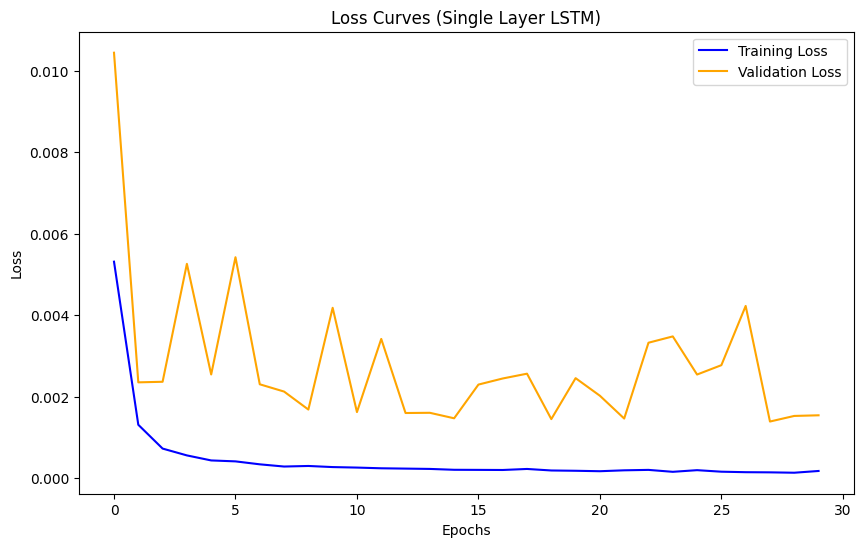

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


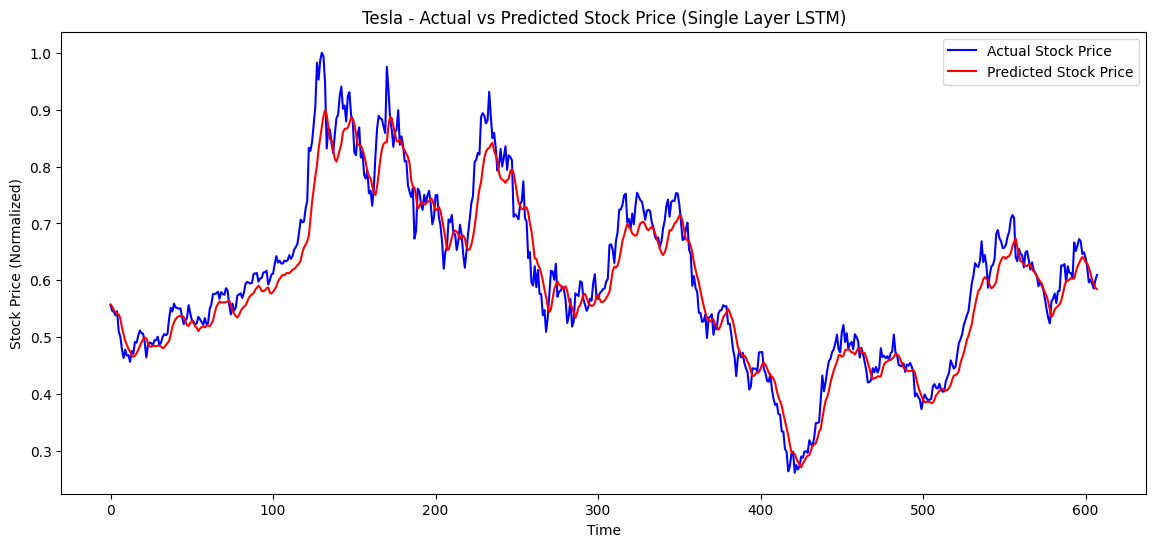

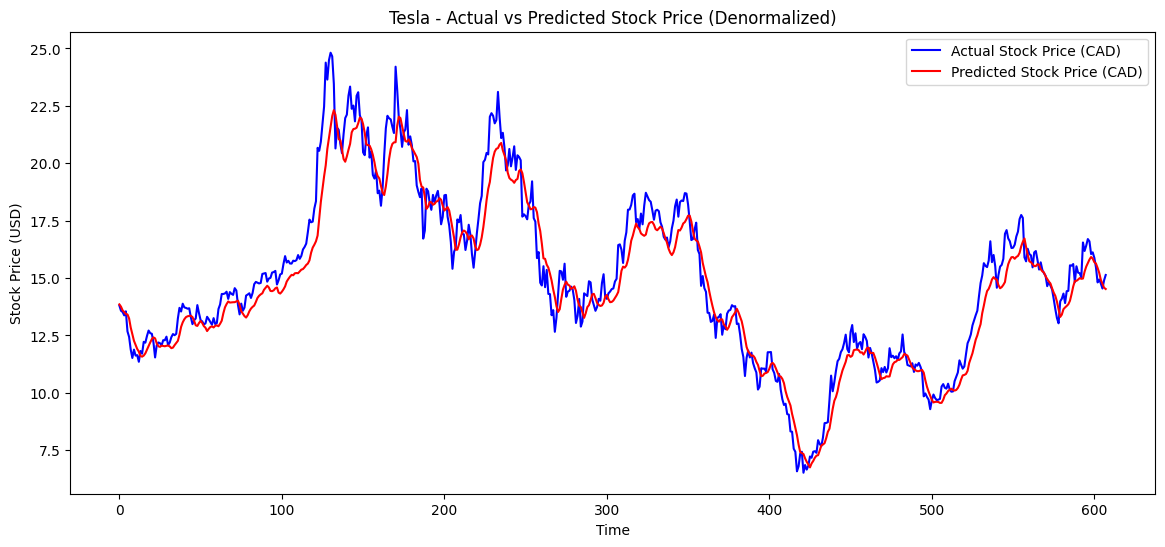

Root Mean Squared Error (RMSE): 0.97 USD
Mean Absolute Error (MAE): 0.74 USD


In [ ]:
# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(
    history_1.history['loss'], label='Training Loss', color='blue'
)
plt.plot(
    history_1.history['val_loss'], label='Validation Loss', color='orange'
)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves (Single Layer LSTM)')
plt.legend()
plt.show()

# Make predictions on the test dataset
y_pred = model_1.predict(X_test)

# Plot the actual vs predicted stock prices (normalized)
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual Stock Price', color='blue')
plt.plot(y_pred, label='Predicted Stock Price', color='red')
plt.xlabel('Time')
plt.ylabel('Stock Price (Normalized)')
plt.title('Tesla - Actual vs Predicted Stock Price (Single Layer LSTM)')
plt.legend()
plt.show()

# Denormalize the predictions and actual values to compare on the original scale
y_test_denorm = scaler.inverse_transform(
    np.concatenate(
        (
            np.zeros((y_test.shape[0], scaled_data.shape[1] - 1)),
            y_test.reshape(-1, 1)
        ),
        axis=1
    )
)[:, -1]

y_pred_denorm = scaler.inverse_transform(
    np.concatenate(
        (
            np.zeros((y_pred.shape[0], scaled_data.shape[1] - 1)),
            y_pred.reshape(-1, 1)
        ),
        axis=1
    )
)[:, -1]

# Plot the actual vs predicted stock prices (denormalized)
plt.figure(figsize=(14, 6))
plt.plot(
    y_test_denorm, label='Actual Stock Price (CAD)', color='blue'
)
plt.plot(
    y_pred_denorm, label='Predicted Stock Price (CAD)', color='red'
)
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.title('Tesla - Actual vs Predicted Stock Price (Denormalized)')
plt.legend()
plt.show()

# Calculate and print RMSE and MAE for the model
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test_denorm, y_pred_denorm))
mae = mean_absolute_error(y_test_denorm, y_pred_denorm)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f} USD")
print(f"Mean Absolute Error (MAE): {mae:.2f} USD")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


<ipython-input-16-ed94afebace5>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[3] = predicted_price


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


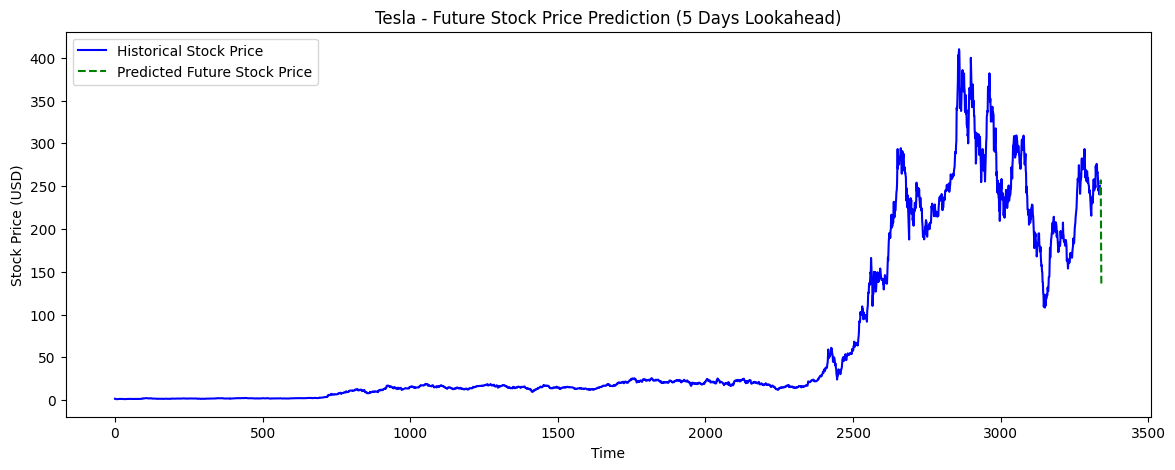

In [ ]:
# Define the function for future predictions using a stabilized approach
def predict_future_prices_stabilized(
    model, data, lookback, n_predictions, true_data_fraction=0.5
):
    # Get the last 'lookback' number of days from the scaled dataset
    input_seq = data[-lookback:]
    predicted_prices = []

    # Predict 'n_predictions' into the future
    for i in range(n_predictions):
        # Reshape the input sequence for prediction
        input_seq_reshaped = input_seq.reshape((1, lookback, data.shape[1]))
        predicted_price = model.predict(input_seq_reshaped)

        # Append the predicted price to the list
        predicted_prices.append(predicted_price[0][0])

        # Create a new row to append to the sequence
        new_row = np.zeros((data.shape[1],))
        new_row[3] = predicted_price

        # Update the input sequence for the next prediction
        if i < int(n_predictions * true_data_fraction):
            # Use the original input data (less noise) for the first few predictions
            input_seq = np.append(
                input_seq[1:], [data[-lookback + i + 1]], axis=0
            )
        else:
            # Use predicted data for subsequent predictions
            input_seq = np.append(input_seq[1:], [new_row], axis=0)

    # Convert the predicted prices list to a numpy array
    predicted_prices = np.array(predicted_prices).reshape(-1, 1)

    # Inverse transform predictions to original scale
    original_data_part = np.zeros((n_predictions, data.shape[1]))
    original_data_part[:, 3] = predicted_prices[:, 0]  # 'Close' price at index 3
    predicted_prices_original_scale = scaler.inverse_transform(
        original_data_part
    )[:, 3]

    return predicted_prices_original_scale


# Define parameters for the future prediction
n_days = 5  # Predict the next 5 days of stock prices

# Predict the future stock prices
predicted_future_prices_stabilized = predict_future_prices_stabilized(
    model_1, scaled_data, lookback_period, n_days
)

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(
    range(len(stock_data)), stock_data['Close'],
    color='blue', label='Historical Stock Price'
)
plt.plot(
    range(len(stock_data), len(stock_data) + n_days),
    predicted_future_prices_stabilized, color='green', linestyle='--',
    label='Predicted Future Stock Price'
)
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.title(f'Tesla - Future Stock Price Prediction ({n_days} Days Lookahead)')
plt.legend()
plt.show()

In [ ]:
# Build stacked LSTM model without L2 regularization
model_stacked_no_l2 = Sequential()
model_stacked_no_l2.add(
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))
)
model_stacked_no_l2.add(LSTM(50, return_sequences=False))
model_stacked_no_l2.add(Dropout(0.2))
model_stacked_no_l2.add(Dense(1))

# Compile the model
model_stacked_no_l2.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history_stacked_no_l2 = model_stacked_no_l2.fit(
    X_train, y_train, validation_data=(X_test, y_test),
    epochs=30, batch_size=64
)

# Evaluate the model
train_loss_no_l2 = model_stacked_no_l2.evaluate(X_train, y_train, verbose=0)
test_loss_no_l2 = model_stacked_no_l2.evaluate(X_test, y_test, verbose=0)
print(
    f"Stacked LSTM Without L2 Regularization - Train Loss: {train_loss_no_l2:.4f}, "
    f"Test Loss: {test_loss_no_l2:.4f}"
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0083 - val_loss: 0.0090
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.6681e-04 - val_loss: 0.0083
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.8635e-04 - val_loss: 0.0047
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.0423e-04 - val_loss: 0.0083
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7816e-04 - val_loss: 0.0078
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.7413e-04 - val_loss: 0.0048
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4095e-04 - val_loss: 0.0116
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7445e-04 - val_loss: 0.0074
Epoch 9/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8779e-04 - val_loss: 0.0044
Epoch 10/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1024e-04 - val_loss: 0.0074
Epoch 11/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.4389e-04 - val_loss: 0.0114
Epoch 12/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 1

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


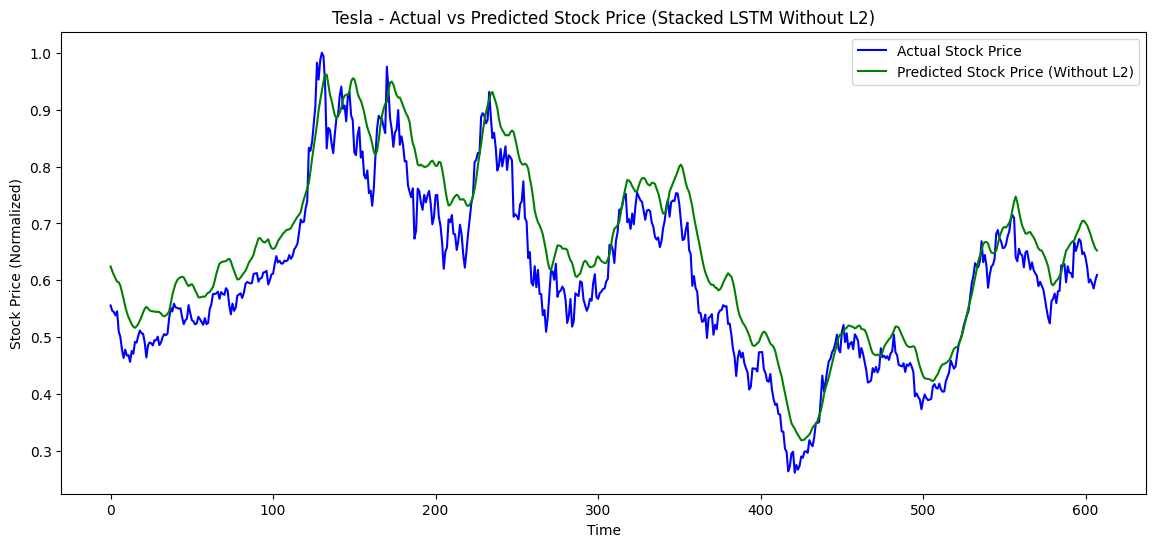

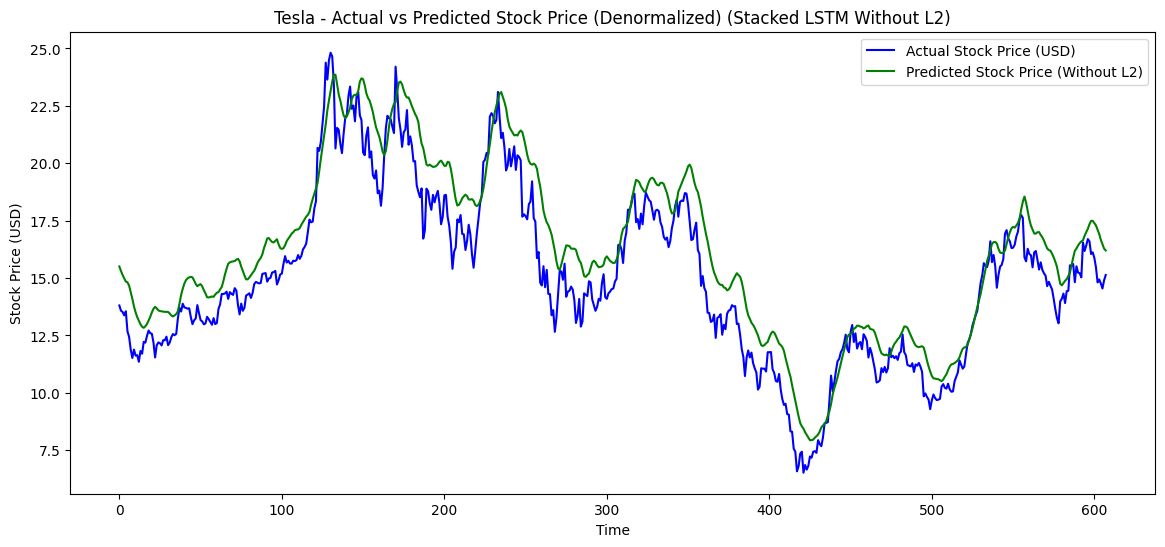

Root Mean Squared Error (RMSE) Without L2: 1.55 USD
Mean Absolute Error (MAE) Without L2: 1.31 USD
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


<ipython-input-16-ed94afebace5>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[3] = predicted_price


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


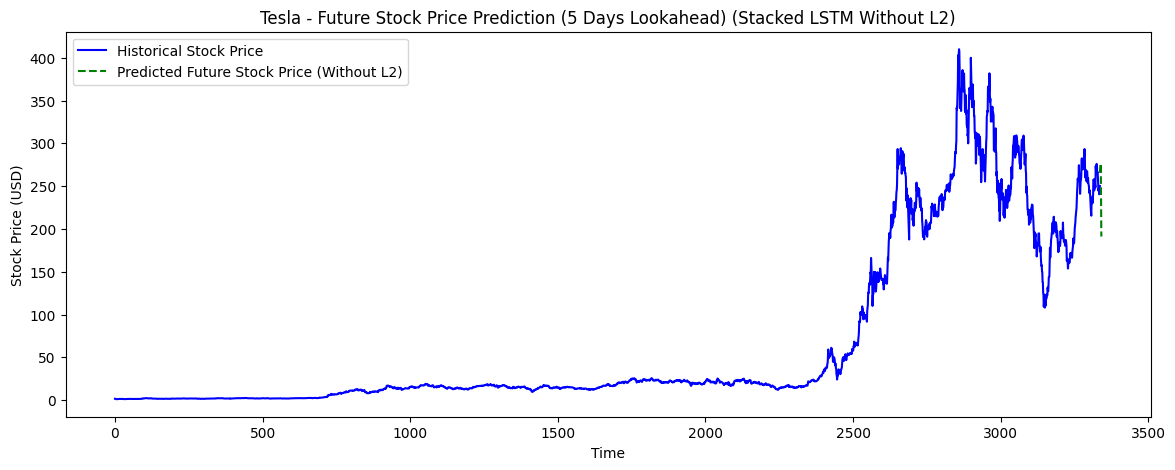

In [ ]:
# Make predictions on the test dataset using stacked LSTM (without L2 regularization)
y_pred_stacked_no_l2 = model_stacked_no_l2.predict(X_test)

# Plot the actual vs predicted stock prices (normalized)
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual Stock Price', color='blue')
plt.plot(
    y_pred_stacked_no_l2, label='Predicted Stock Price (Without L2)',
    color='green'
)
plt.xlabel('Time')
plt.ylabel('Stock Price (Normalized)')
plt.title(
    'Tesla - Actual vs Predicted Stock Price (Stacked LSTM Without L2)'
)
plt.legend()
plt.show()

# Denormalize the predictions and actual values
y_test_denorm_stacked_no_l2 = scaler.inverse_transform(
    np.concatenate(
        (
            np.zeros((y_test.shape[0], scaled_data.shape[1] - 1)),
            y_test.reshape(-1, 1)
        ),
        axis=1
    )
)[:, -1]
y_pred_denorm_stacked_no_l2 = scaler.inverse_transform(
    np.concatenate(
        (
            np.zeros(
                (y_pred_stacked_no_l2.shape[0], scaled_data.shape[1] - 1)
            ),
            y_pred_stacked_no_l2.reshape(-1, 1)
        ),
        axis=1
    )
)[:, -1]

# Plot the actual vs predicted stock prices (denormalized)
plt.figure(figsize=(14, 6))
plt.plot(
    y_test_denorm_stacked_no_l2, label='Actual Stock Price (USD)',
    color='blue'
)
plt.plot(
    y_pred_denorm_stacked_no_l2,
    label='Predicted Stock Price (Without L2)',
    color='green'
)
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.title(
    'Tesla - Actual vs Predicted Stock Price (Denormalized) '
    '(Stacked LSTM Without L2)'
)
plt.legend()
plt.show()

# Calculate and print RMSE and MAE for the model without L2 regularization
rmse_stacked_no_l2 = np.sqrt(
    mean_squared_error(
        y_test_denorm_stacked_no_l2, y_pred_denorm_stacked_no_l2
    )
)
mae_stacked_no_l2 = np.mean(
    np.abs(y_test_denorm_stacked_no_l2 - y_pred_denorm_stacked_no_l2)
)

print(f"Root Mean Squared Error (RMSE) Without L2: {rmse_stacked_no_l2:.2f} USD")
print(f"Mean Absolute Error (MAE) Without L2: {mae_stacked_no_l2:.2f} USD")

# Predict the future stock prices using the stabilized approach for the non-L2 model
n_days = 5  # Predict the next 5 days of stock prices
predicted_future_prices_stabilized_stacked_no_l2 = predict_future_prices_stabilized(
    model_stacked_no_l2, scaled_data, lookback_period, n_days
)

# Plot the results for future prediction using the non-L2 model
plt.figure(figsize=(14, 5))
plt.plot(
    range(len(stock_data)), stock_data['Close'],
    color='blue', label='Historical Stock Price'
)
plt.plot(
    range(len(stock_data), len(stock_data) + n_days),
    predicted_future_prices_stabilized_stacked_no_l2,
    color='green', linestyle='--',
    label='Predicted Future Stock Price (Without L2)'
)
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.title(
    f'Tesla - Future Stock Price Prediction ({n_days} Days Lookahead) '
    '(Stacked LSTM Without L2)'
)
plt.legend()
plt.show()

In [ ]:
# Define L2 regularization strength
l2_strength = 0.001

# Build stacked LSTM model with L2 regularization
model_stacked = Sequential()
model_stacked.add(
    LSTM(
        50, return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2]),
        kernel_regularizer=l2(l2_strength)
    )
)
model_stacked.add(
    LSTM(
        50, return_sequences=False,
        kernel_regularizer=l2(l2_strength)
    )
)
model_stacked.add(Dropout(0.2))
model_stacked.add(Dense(1, kernel_regularizer=l2(l2_strength)))

# Compile the model
model_stacked.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history_stacked = model_stacked.fit(
    X_train, y_train, validation_data=(X_test, y_test),
    epochs=30, batch_size=64
)

# Evaluate the model
train_loss_stacked = model_stacked.evaluate(X_train, y_train, verbose=0)
test_loss_stacked = model_stacked.evaluate(X_test, y_test, verbose=0)
print(
    f"Stacked LSTM with L2 Regularization - Train Loss: {train_loss_stacked:.4f}, "
    f"Test Loss: {test_loss_stacked:.4f}"
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0968 - val_loss: 0.0601
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0461 - val_loss: 0.0324
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0219 - val_loss: 0.0179
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0107 - val_loss: 0.0249
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0059 - val_loss: 0.0216
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0036 - val_loss: 0.0281
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0025 - val_loss: 0.0345
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - val_loss: 0.0118
Epoch 9/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017 - val_loss: 0.0304
Epoch 10/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - val_loss: 0.0408
Epoch 11/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - val_loss: 0.0248
Epoch 12/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - val_loss: 

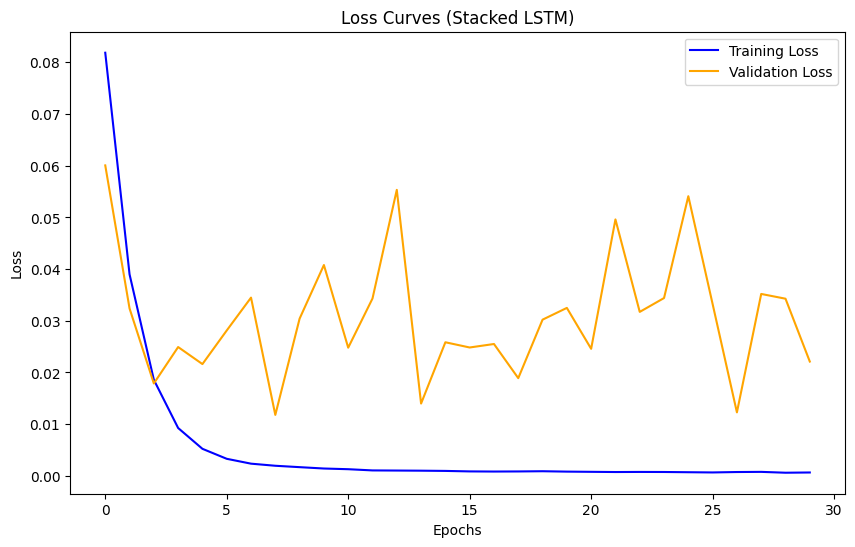

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


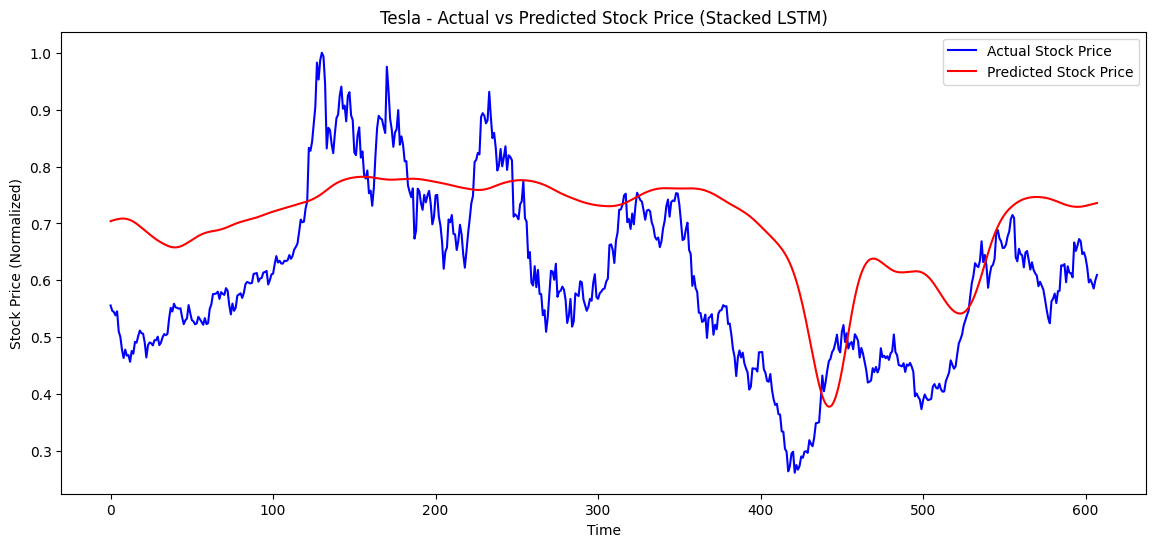

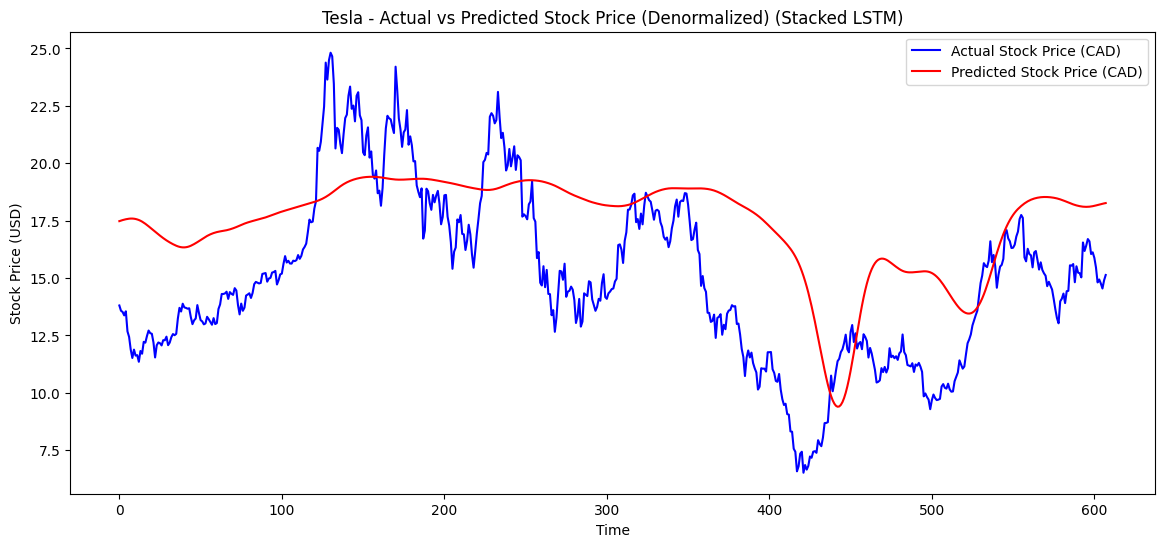

Root Mean Squared Error (RMSE): 3.66 USD
Mean Absolute Error (MAE): 3.14 USD
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


<ipython-input-16-ed94afebace5>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[3] = predicted_price


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


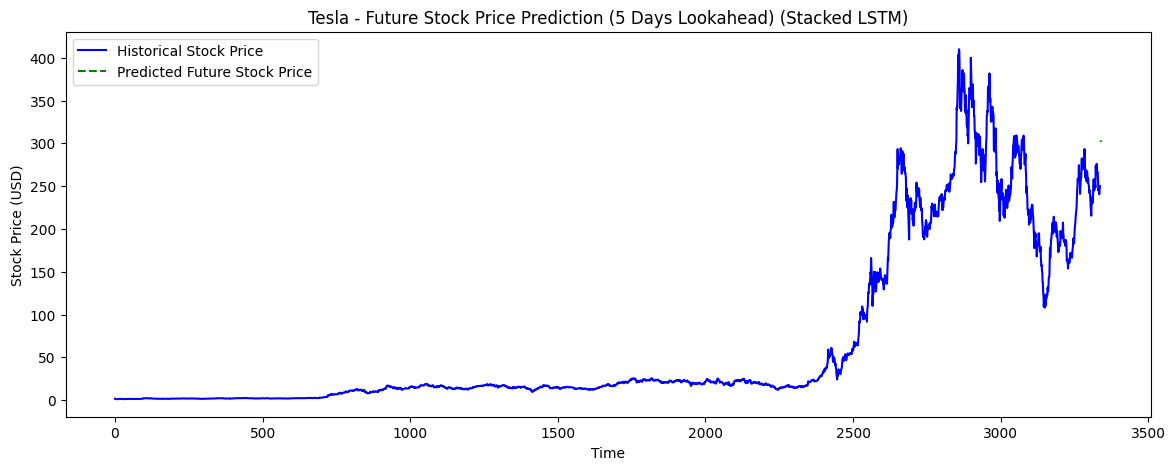

In [ ]:
# Plot the training and validation loss curves for the stacked LSTM model
plt.figure(figsize=(10, 6))
plt.plot(
    history_stacked.history['loss'], label='Training Loss', color='blue'
)
plt.plot(
    history_stacked.history['val_loss'], label='Validation Loss',
    color='orange'
)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves (Stacked LSTM)')
plt.legend()
plt.show()

# Make predictions on the test dataset using stacked LSTM
y_pred_stacked = model_stacked.predict(X_test)

# Plot the actual vs predicted stock prices (normalized)
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual Stock Price', color='blue')
plt.plot(y_pred_stacked, label='Predicted Stock Price', color='red')
plt.xlabel('Time')
plt.ylabel('Stock Price (Normalized)')
plt.title('Tesla - Actual vs Predicted Stock Price (Stacked LSTM & L2)')
plt.legend()
plt.show()

# Denormalize the predictions and actual values
y_test_denorm_stacked = scaler.inverse_transform(
    np.concatenate(
        (
            np.zeros((y_test.shape[0], scaled_data.shape[1] - 1)),
            y_test.reshape(-1, 1)
        ),
        axis=1
    )
)[:, -1]
y_pred_denorm_stacked = scaler.inverse_transform(
    np.concatenate(
        (
            np.zeros((y_pred_stacked.shape[0], scaled_data.shape[1] - 1)),
            y_pred_stacked.reshape(-1, 1)
        ),
        axis=1
    )
)[:, -1]

# Plot the actual vs predicted stock prices (denormalized)
plt.figure(figsize=(14, 6))
plt.plot(
    y_test_denorm_stacked, label='Actual Stock Price (CAD)', color='blue'
)
plt.plot(
    y_pred_denorm_stacked, label='Predicted Stock Price (CAD)',
    color='red'
)
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.title(
    'Tesla - Actual vs Predicted Stock Price (Denormalized) '
    '(Stacked LSTM & L2)'
)
plt.legend()
plt.show()

# Calculate and print RMSE and MAE for the stacked LSTM model
rmse_stacked = np.sqrt(
    mean_squared_error(
        y_test_denorm_stacked, y_pred_denorm_stacked
    )
)
mae_stacked = mean_absolute_error(
    y_test_denorm_stacked, y_pred_denorm_stacked
)

print(f"Root Mean Squared Error (RMSE): {rmse_stacked:.2f} USD")
print(f"Mean Absolute Error (MAE): {mae_stacked:.2f} USD")

# Predict the future stock prices using the stabilized approach for stacked LSTM
n_days = 5  # Predict the next 5 days of stock prices
predicted_future_prices_stabilized_stacked = predict_future_prices_stabilized(
    model_stacked, scaled_data, lookback_period, n_days
)

# Plot the results for future prediction using stacked LSTM
plt.figure(figsize=(14, 5))
plt.plot(
    range(len(stock_data)), stock_data['Close'], color='blue',
    label='Historical Stock Price'
)
plt.plot(
    range(len(stock_data), len(stock_data) + n_days),
    predicted_future_prices_stabilized_stacked, color='green',
    linestyle='--', label='Predicted Future Stock Price'
)
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.title(
    f'Tesla - Future Stock Price Prediction ({n_days} Days Lookahead) '
    '(Stacked LSTM & L2)'
)
plt.legend()
plt.show()

In [ ]:
# Define Bidirectional LSTM Model
model_bidir = Sequential()
model_bidir.add(
    Bidirectional(
        LSTM(50, return_sequences=False),
        input_shape=(X_train.shape[1], X_train.shape[2])
    )
)
model_bidir.add(Dropout(0.2))
model_bidir.add(Dense(1))

# Compile the model
model_bidir.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history_bidir = model_bidir.fit(
    X_train, y_train, validation_data=(X_test, y_test),
    epochs=30, batch_size=64
)

# Evaluate the model
train_loss_bidir = model_bidir.evaluate(X_train, y_train, verbose=0)
test_loss_bidir = model_bidir.evaluate(X_test, y_test, verbose=0)
print(
    f"Bidirectional LSTM - Train Loss: {train_loss_bidir:.4f}, "
    f"Test Loss: {test_loss_bidir:.4f}"
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0042 - val_loss: 0.0378
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012 - val_loss: 0.0475
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.8296e-04 - val_loss: 0.0317
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.2462e-04 - val_loss: 0.0375
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.9214e-04 - val_loss: 0.0166
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9427e-04 - val_loss: 0.0170
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.0609e-04 - val_loss: 0.0097
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7989e-04 - val_loss: 0.0160
Epoch 9/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.3065e-04 - val_loss: 0.0132
Epoch 10/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.8244e-04 - val_loss: 0.0058
Epoch 11/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.2298e-04 - val_loss: 0.0102
Epoch 12/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/

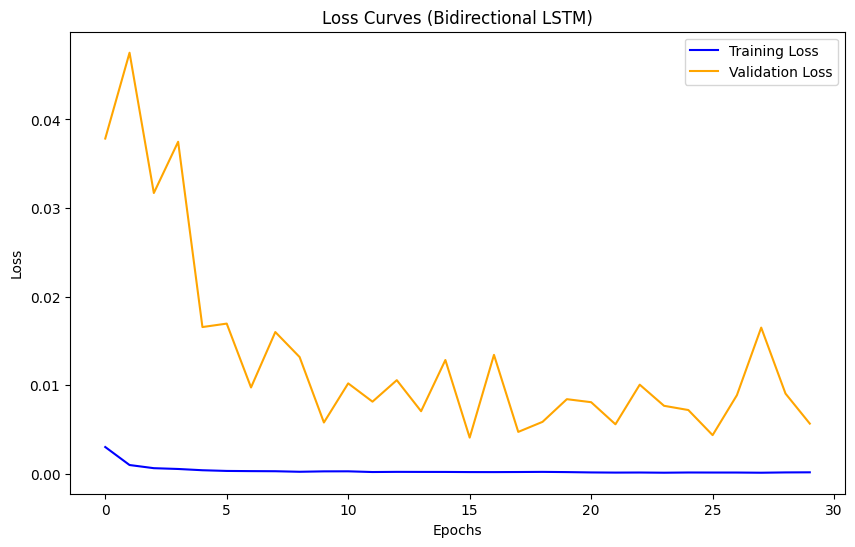

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


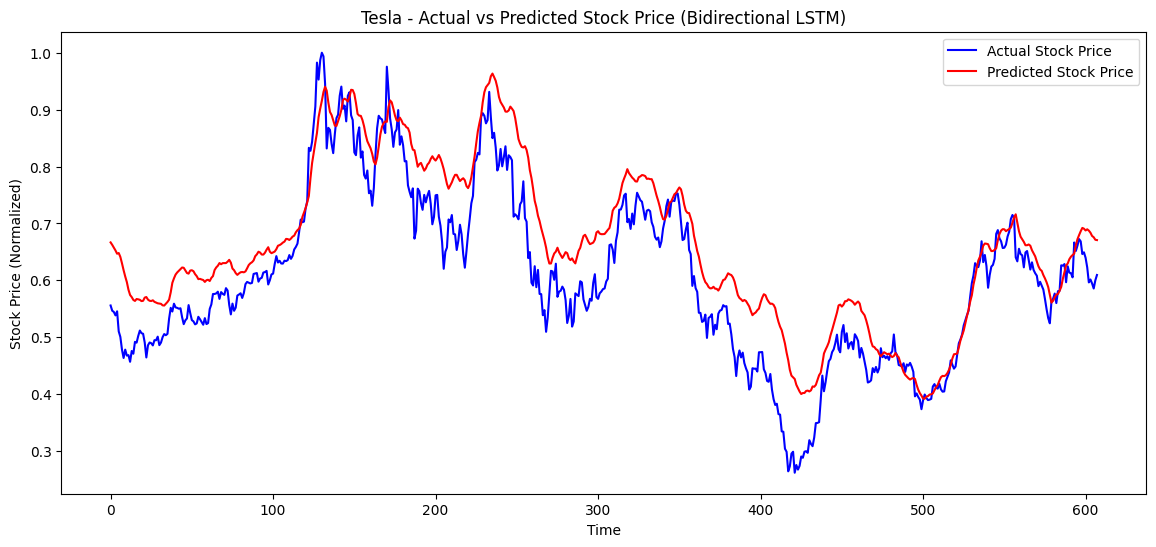

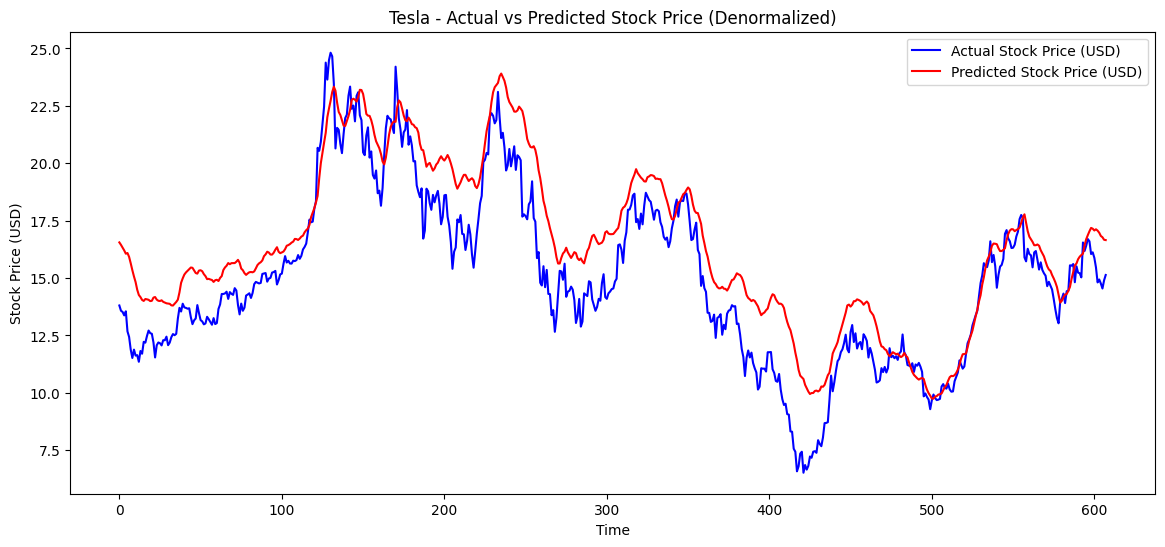

Root Mean Squared Error (RMSE): 1.87 USD
Mean Absolute Error (MAE): 1.54 USD
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


<ipython-input-16-ed94afebace5>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[3] = predicted_price


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


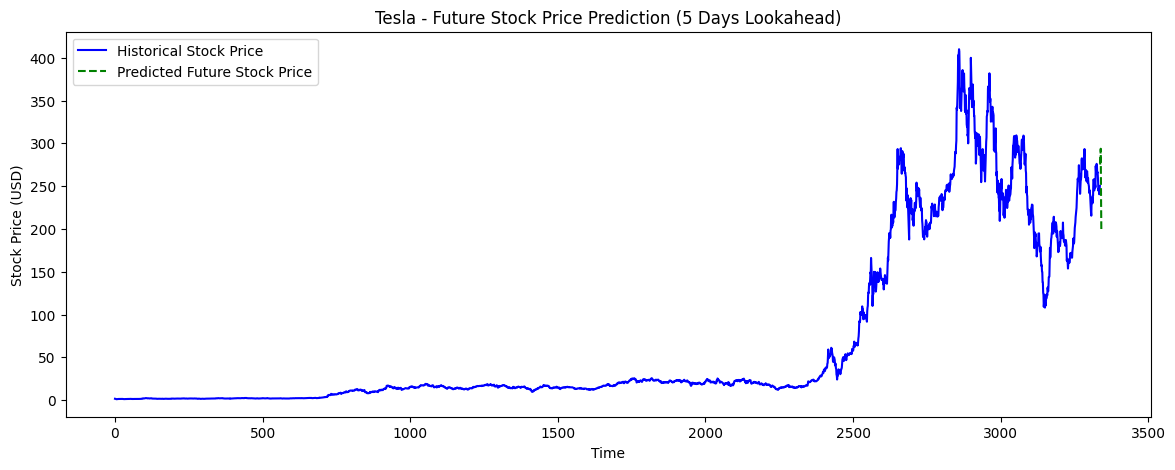

In [ ]:
# Plot the training and validation loss curves for the last trained model
plt.figure(figsize=(10, 6))
plt.plot(
    history_bidir.history['loss'], label='Training Loss', color='blue'
)
plt.plot(
    history_bidir.history['val_loss'], label='Validation Loss',
    color='orange'
)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves (Bidirectional LSTM)')
plt.legend()
plt.show()

# Make predictions on the test dataset
y_pred = model_bidir.predict(X_test)

# Plot the actual vs predicted stock prices (normalized)
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual Stock Price', color='blue')
plt.plot(y_pred, label='Predicted Stock Price', color='red')
plt.xlabel('Time')
plt.ylabel('Stock Price (Normalized)')
plt.title('Tesla - Actual vs Predicted Stock Price (Bidirectional LSTM)')
plt.legend()
plt.show()

# Denormalize the predictions and actual values
y_test_denorm = scaler.inverse_transform(
    np.concatenate(
        (
            np.zeros((y_test.shape[0], scaled_data.shape[1] - 1)),
            y_test.reshape(-1, 1)
        ),
        axis=1
    )
)[:, -1]
y_pred_denorm = scaler.inverse_transform(
    np.concatenate(
        (
            np.zeros((y_pred.shape[0], scaled_data.shape[1] - 1)),
            y_pred.reshape(-1, 1)
        ),
        axis=1
    )
)[:, -1]

# Plot the actual vs predicted stock prices (denormalized)
plt.figure(figsize=(14, 6))
plt.plot(y_test_denorm, label='Actual Stock Price (USD)', color='blue')
plt.plot(y_pred_denorm, label='Predicted Stock Price (USD)', color='red')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.title('Tesla - Actual vs Predicted Stock Price (Denormalized)')
plt.legend()
plt.show()

# Calculate and print RMSE and MAE for the model
rmse = np.sqrt(mean_squared_error(y_test_denorm, y_pred_denorm))
mae = mean_absolute_error(y_test_denorm, y_pred_denorm)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f} USD")
print(f"Mean Absolute Error (MAE): {mae:.2f} USD")

# Predict the future stock prices using the stabilized approach
n_days = 5  # Predict the next 5 days of stock prices
predicted_future_prices_stabilized = predict_future_prices_stabilized(
    model_bidir, scaled_data, lookback_period, n_days
)

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(
    range(len(stock_data)), stock_data['Close'], color='blue',
    label='Historical Stock Price'
)
plt.plot(
    range(len(stock_data), len(stock_data) + n_days),
    predicted_future_prices_stabilized, color='green', linestyle='--',
    label='Predicted Future Stock Price'
)
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.title(
    f'Tesla - Future Stock Price Prediction ({n_days} Days Lookahead)'
)
plt.legend()
plt.show()

### Summary of Errors

| Model                                | RMSE (USD) | MAE (USD) |
|--------------------------------------|------------|-----------|
| **Single Layer LSTM**                | 0.97       | 0.74      |
| **Stacked LSTM without L2 Regularization** | 1.55       | 1.31      |
| **Stacked LSTM with L2 Regularization**    | 3.66       | 3.14      |
| **Bidirectional LSTM**               | 1.87       | 1.54      |

### Analysis:

1. **Single Layer LSTM:**
   - This model performed the best overall, achieving the lowest RMSE (0.97 USD) and MAE (0.74 USD).
   - The predictions closely followed the actual stock prices, indicating good generalization without overfitting.

2. **Stacked LSTM without L2 Regularization:**
   - The model showed a slight increase in both RMSE (1.55 USD) and MAE (1.31 USD) compared to the single-layer LSTM.
   - The predictions captured the general trend but exhibited a lag compared to the actual stock prices.

3. **Stacked LSTM with L2 Regularization:**
   - This model had the highest RMSE (3.66 USD) and MAE (3.14 USD), suggesting over-regularization.
   - The L2 penalty appears to have constrained the model too much, resulting in underfitting and poorer predictions.

4. **Bidirectional LSTM:**
   - The bidirectional LSTM provided a balanced performance with an RMSE of 1.87 USD and an MAE of 1.54 USD.
   - It managed to capture some complex patterns but did not outperform the simpler single-layer LSTM model, possibly due to increased model complexity and overfitting.

### Conclusion:
The **Single Layer LSTM** model outperformed the more complex architectures in this analysis, achieving the best predictive accuracy with the lowest error metrics. The results indicate that increasing model complexity (e.g., using stacked or bidirectional LSTMs) does not necessarily lead to better performance, particularly when over-regularization or overfitting occurs.


# Challenges Faced
During the experimentation phase, several challenges were encountered:
- **Overfitting**: Especially observed with deeper LSTMs, leading us to add L2 regularization and dropout to mitigate the issue.
- **Slow Convergence**: With certain hyperparameter combinations, convergence was slower, affecting training time.
- **Scaling and Prediction Alignment**: Challenges in scaling the data and ensuring correct shapes for predictions during multi-step forecasting were also experienced. These were addressed by refining the scaling approach and using `MinMaxScaler`.


### Future Steps

1. **Incorporate Sentiment Analysis**:
   - Integrate sentiment analysis from financial news and social media to capture market sentiment as an additional feature.
   - Use a pre-trained sentiment analysis model to extract sentiment scores for each day and add them to the input features.

2. **Include External Economic Factors**:
   - Add relevant external economic indicators, such as interest rates, inflation, and employment data, to enrich the feature set and provide a more comprehensive input for predicting stock prices.
   - Explore correlations between these factors and historical stock prices to identify meaningful relationships.

3. **Model Tuning and Experimentation**:
   - Further tune hyperparameters like the learning rate, batch size, and dropout rate to optimize model performance.
   - Experiment with additional regularization techniques such as dropout and batch normalization to prevent overfitting.
   - Test advanced architectures like GRU (Gated Recurrent Unit) and Transformer-based models to improve predictive accuracy.

4. **Time Horizon Analysis**:
   - Conduct experiments with different lookback periods to assess the impact on prediction accuracy.
   - Investigate the effects of varying the prediction horizon, from short-term (e.g., 5 days) to longer-term forecasts.

5. **Ensemble Methods**:
   - Explore ensemble models by combining the outputs of different LSTM architectures to potentially reduce prediction errors.
   - Use techniques like weighted averaging to improve the robustness of future predictions.

6. **Feedback Incorporation**:
   - Based on instructor feedback from the mid-progress meeting, refine model architecture and approach to address identified limitations and improve performance.